In [11]:
%config IPCompleter.greedy = True
%config IPCompleter.use_jedi = False


# Set Up


In [12]:
import time

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA, TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score, silhouette_samples, mean_squared_error, accuracy_score, confusion_matrix
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split, validation_curve, learning_curve, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.random_projection import GaussianRandomProjection

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
from numpy import linalg as LA

import scipy
import scipy.stats
from scipy.linalg import pinv

import pandas as pd

import itertools

import warnings
warnings.filterwarnings('ignore')


# Data Preprocessing


In [13]:
data = pd.read_csv('data/breast-cancer-wisconsin.data')
data.drop(['id', 'Unnamed: 32'], axis=1, inplace=True)

FEATURES = preprocessing.scale(data.drop(['diagnosis'], axis=1))
TARGET = data["diagnosis"]

print(f"Number of samples: {TARGET.size}")
print(
    f"Percentage of Malignment: {TARGET.value_counts(normalize=True)['M'] * 100:.3f}%")
print(
    f"Percentage of Benign: {TARGET.value_counts(normalize=True)['B'] * 100:.3f}%")

data["diagnosis"] = preprocessing.OrdinalEncoder().fit_transform(data[["diagnosis"]])
TARGET = data["diagnosis"].astype(int)

print("Splitting into train/test sets...", end="")
FEATURES_TRAIN, FEATURES_TEST, TARGET_TRAIN, TARGET_TEST = train_test_split(
    FEATURES, TARGET, test_size=0.3, random_state=42)
print("Done")

print("Setting up global variables...", end="")
classifier_accuracy = np.zeros(6)
train_time = np.zeros(6)
infer_time = np.zeros(6)
print("Done")

Number of samples: 569
Percentage of Malignment: 37.258%
Percentage of Benign: 62.742%
Splitting into train/test sets...Done
Setting up global variables...Done


# Helper Functions


In [14]:
# Code taken from scikit-learn examples (https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
def silhouette_analysis(name, range_n_clusters, features):
    max_score = 0
    best_n_clusters = 0
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (best_n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(features) + (best_n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(features)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(features, cluster_labels)
        print(f"For n_clusters={n_clusters}, The average silhouette_score is: {silhouette_avg}")
        if silhouette_avg > max_score:
            max_score = silhouette_avg
            best_n_clusters = n_clusters

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(features, cluster_labels)

        y_lower = 10
        for i in range(best_n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / best_n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / best_n_clusters)
        ax2.scatter(
            features[:, 0], features[:, 1], marker=".",
            s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
        )

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(
            centers[:, 0], centers[:, 1], marker="o",
            c="white", alpha=1, s=200, edgecolor="k"
        )

        for i, c in enumerate(centers):
            ax2.scatter(
                c[0], c[1], marker=f"${i}$",
                alpha=1, s=50, edgecolor="k"
            )

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(
            f"Silhouette analysis for KMeans clustering on sample data with the best No. of clusters = {best_n_clusters}",
            fontsize=14,
            fontweight="bold",
        )
    plt.savefig(f'images/bcw/{name}_silhouette.png')
    plt.show()

    return best_n_clusters


In [15]:
def plot_features_visualization(clustering_method, dim_reduction_method, labels, features, target, np_seed):
    np.random.seed(np_seed)
    data_viz = pd.DataFrame(features)
    data_viz['diagnosis'] = target
    data_viz['cluster_class'] = labels

    idx_viz = np.append(np.random.randint(
        0, data_viz.shape[1] - 2, 5), [data_viz.shape[1] - 2, data_viz.shape[1] - 1])

    plt.figure(figsize=(8, 6))
    pd.plotting.parallel_coordinates(
        data_viz.iloc[:, idx_viz], 'cluster_class', colormap='jet')
    plt.xticks(rotation=45)
    plt.xlabel('Feature')
    plt.ylabel('Standardized Value')
    if dim_reduction_method == None:
      plt.title(f'Parallel Coordinates Visualization for {clustering_method}')
      plt.savefig(f'images/bcw/{clustering_method}_parallel_coordinates.png')
    else:
      plt.title(f'Parallel Coordinates Visualization for {clustering_method} ({dim_reduction_method.upper()})')
      plt.savefig(f'images/bcw/{clustering_method}_parallel_coordinates_{dim_reduction_method}.png')
    plt.tight_layout()

    for i in range(max(labels) + 1):
        print(data[data_viz['cluster_class'] == i]['diagnosis'].value_counts())


In [16]:
def plot_reduced_dataset(name, features_3d):
  fig = plt.figure()
  ax = Axes3D(fig)
  for i in range(len(TARGET)):
      if TARGET[i] == 0:
          ax.scatter(features_3d[i, :][0], features_3d[i, :][1],
                    features_3d[i, :][2], c='g', marker='o', label='0')
      elif TARGET[i] == 1:
          ax.scatter(features_3d[i, :][0], features_3d[i, :][1],
                    features_3d[i, :][2], c='r', marker='o', label='1')
  ax.set_xlabel(f'{name} 1st Component')
  ax.set_ylabel(f'{name} 2nd Component')
  ax.set_zlabel(f'{name} 3rd Component')
  plt.title(f'BCW Dataset Reduced to 3D ({name})')
  plt.show()

In [17]:
def train_neural_network(nn_classifier, features_train, target_train, features_test, target_test, name):
    param_grid = {
      'alpha': np.logspace(-3, 3, 7),
      'hidden_layer_sizes': np.arange(2, 25, 2)
    }
    nn_classifier_best = GridSearchCV(nn_classifier, param_grid=param_grid, cv=4)

    start_time = time.time()
    nn_classifier_best.fit(features_train, target_train)
    end_time = time.time()
    time_train = end_time-start_time
    print("Best params for neural network:",
          nn_classifier_best.best_params_)
    print("Time to train:", time_train)

    start_time = time.time()
    classifier_accuracy = accuracy_score(
        target_test, nn_classifier_best.predict(features_test))
    end_time = time.time()
    time_infer = end_time-start_time
    print("Accuracy for best neural network:", classifier_accuracy)
    print("Time to infer:", time_infer)

    nn_classifier_learning = MLPClassifier(
        random_state=42, max_iter=2000,
        hidden_layer_sizes=nn_classifier_best.best_params_['hidden_layer_sizes'],
        alpha=nn_classifier_best.best_params_['alpha']
    )
    _, train_scores, test_scores = learning_curve(
        nn_classifier_learning,
        features_train,target_train,
        train_sizes=np.linspace(0.1, 1.0, 10), cv=4
    )

    plt.figure()
    plt.plot(np.linspace(0.1, 1.0, 10)*100,
            np.mean(train_scores, axis=1), label='Train Score')
    plt.plot(np.linspace(0.1, 1.0, 10)*100,
            np.mean(test_scores, axis=1), label='CV Score')
    plt.legend()
    plt.title("Learning Curve (Neural Network)")
    plt.xlabel("Percentage of Training Examples")
    plt.ylabel("Score")
    plt.xticks(np.linspace(0.1, 1.0, 10)*100)
    plt.grid()
    plt.savefig(f'images/bcw/neural_network_learning_curve_{name}.png')
    plt.show()

In [18]:
def kmeans_clustering(range_n_clusters, features, target, np_seed, name):
    inertia = []
    for n_clusters in range_n_clusters:
        k_means_clustering = KMeans(n_clusters=n_clusters, random_state=42)
        k_means_clustering.fit(features)
        inertia.append(k_means_clustering.inertia_)

    plt.plot(range_n_clusters, inertia)
    plt.xlabel('Clusters')
    plt.ylabel('Inertia')
    plt.title(f'Clusters vs. Inertia for BCW {name.upper()}')
    plt.grid()
    plt.savefig(f'images/bcw/kmeans_inertia_{name}.png')
    plt.show()

    k = silhouette_analysis("kmeans", range_n_clusters, features)

    k_means_clustering = KMeans(n_clusters=k, random_state=42)
    k_means_clustering.fit(features)
    print('Inertia: ', k_means_clustering.inertia_)
    silhouette_score_value = silhouette_score(features, k_means_clustering.labels_)
    print('Silhouette score: ', silhouette_score_value)
    adjusted_mutual_info_score_value = adjusted_mutual_info_score(
        target, k_means_clustering.labels_)
    print('Adjusted Mutual Information (AMI) score: ',
          adjusted_mutual_info_score_value)

    plt.figure()
    plt.hist(k_means_clustering.labels_, bins=np.arange(
        0, k + 1) - 0.5, rwidth=0.5, zorder=2)
    plt.xticks(np.arange(0, k))
    plt.xlabel('Cluster')
    plt.ylabel('Samples per Cluster')
    plt.title(f'Distribution of data per cluster for K-Means on BCW ({name.upper()})')
    plt.grid()

    plot_features_visualization("kmeans", None, k_means_clustering.labels_, features, target, np_seed)

    

In [19]:
def gmm_clustering(features, target, np_seed, name):
    lowest_bic = np.infty
    num_components_values = range(1, 20)
    covariances = ['spherical', 'tied', 'diag', 'full']
    bic = np.zeros((len(covariances), len(num_components_values)))
    for i, covariance in enumerate(covariances):
        for j, num_components in enumerate(num_components_values):
            gmm = GaussianMixture(n_components=num_components, covariance_type=covariance)
            gmm.fit(FEATURES)
            bic[i][j] = gmm.bic(FEATURES)
            if bic[i][j] < lowest_bic:
                lowest_bic = bic[i][j]
                print("Lowest BIC currently for", covariance, num_components)
                best_gmm = gmm

    plt.figure()
    plt.plot(num_components_values, bic[0], label='Spherical')
    plt.plot(num_components_values, bic[1], label='Tied')
    plt.plot(num_components_values, bic[2], label='Diag')
    plt.plot(num_components_values, bic[3], label='Full')
    plt.legend()
    plt.xticks(num_components_values)
    plt.title("Number of Components vs. BIC for BCW")
    plt.xlabel("Number of Components")
    plt.ylabel("BIC Values")
    plt.savefig('images/bcw/gmm_bic.png')
    plt.show()

    gmm_labels = best_gmm.predict(features)
    silhouette_score_value = silhouette_score(features, gmm_labels)
    print('Silhouette score: ', silhouette_score_value)
    adjusted_mutual_info_score_value = adjusted_mutual_info_score(
        target, gmm_labels)
    print('Adjusted Mutual Information (AMI) score: ',
          adjusted_mutual_info_score_value)

    plt.figure()
    plt.hist(gmm_labels, bins=np.arange(0, 3) - 0.5, rwidth=0.5, zorder=2)
    plt.xticks(np.arange(0, 2))
    plt.xlabel('Cluster')
    plt.ylabel('Samples per Cluster')
    plt.title('Distribution of data per cluster for GMM on BCW')
    plt.grid()

    plot_features_visualization("gmm", None, gmm_labels, features, target, np_seed)


# Clustering


## K-Means

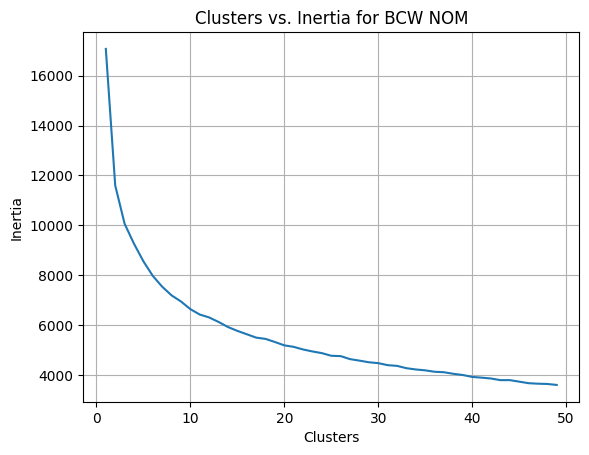

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [20]:
kmeans_clustering(np.arange(1, 50, 1), FEATURES, TARGET, 40, "nom")


## EM (GMM)

In [ ]:
gmm_clustering(FEATURES, TARGET, 40, "nom")


# Dimensionality Reduction

## PCA

In [ ]:
pca = PCA()
pca.fit(FEATURES)


In [ ]:
plt.figure()
plt.plot(np.arange(1, pca.explained_variance_ratio_.size + 1),
         pca.explained_variance_ratio_)
plt.xticks(np.arange(1, pca.explained_variance_ratio_.size + 1, 2))
plt.xlabel('Component')
plt.ylabel('Variance')
plt.title('Variance vs. PCA Component for BCW')
plt.grid()

plt.figure()
plt.plot(np.arange(1, pca.explained_variance_ratio_.size + 1),
         pca.explained_variance_ratio_, label='var')
plt.plot(np.arange(1, pca.explained_variance_ratio_.size + 1),
         np.cumsum(pca.explained_variance_ratio_), label='cum var')
plt.xticks(np.arange(1, pca.explained_variance_ratio_.size + 1, 2))
plt.xlabel('Component')
plt.ylabel('Variance')
plt.title('Cumulative Variance vs. PCA Component for BCW')
plt.legend()
plt.grid()
plt.savefig('images/bcw/pca_variance.png')


In [ ]:
plot_reduced_dataset("PCA", PCA(n_components=3).fit_transform(FEATURES))


In [ ]:
FEATURES_PCA = PCA(n_components=6).fit_transform(FEATURES)
FEATURES_PCA_TRAIN, FEATURES_PCA_TEST, TARGET_PCA_TRAIN, TARGET_PCA_TEST = train_test_split(
    FEATURES_PCA, TARGET, test_size=0.3, random_state=42)


## ICA

In [ ]:
kurtosis_values = []
for i in range(1, 30):
    FEATURES_ICA = FastICA(n_components=i).fit_transform(FEATURES)
    kur = scipy.stats.kurtosis(FEATURES_ICA)
    kurtosis_values.append(np.mean(kur)/i)
kurtosis_values = np.array(kurtosis_values)


In [ ]:
plt.plot(np.arange(1, 30), kurtosis_values)
plt.xlabel('Components')
plt.ylabel('Normalized Mean Kurtosis Value')
plt.grid()
plt.title('Normalized Mean Kurtosis Value vs. Components (BCW)')
plt.savefig('images/bcw/ica_kurtosis.png')
plt.show()


In [ ]:
plot_reduced_dataset("ICA", FastICA(n_components=3).fit_transform(FEATURES))


In [ ]:
FEATURES_ICA = FastICA(n_components=np.argmax(
    kurtosis_values)+1).fit_transform(FEATURES)
FEATURES_ICA_TRAIN, FEATURES_ICA_TEST, TARGET_ICA_TRAIN, TARGET_ICA_TEST = train_test_split(
    FEATURES_ICA, TARGET, test_size=0.3, random_state=42)


## RP

In [ ]:
reconstruction_error = []
reconstruction_variance = []
for i in range(1, 30):
    mean_mse = []
    for j in range(0, 100):
        rp = GaussianRandomProjection(n_components=i)
        FEATURES_RP = rp.fit(FEATURES)
        w = FEATURES_RP.components_
        p = pinv(w)
        reconstructed = ((p@w)@(FEATURES.T)).T
        mean_mse.append(mean_squared_error(FEATURES, reconstructed))
    reconstruction_variance.append(np.std(mean_mse))
    reconstruction_error.append(np.mean(mean_mse))
reconstruction_error = np.array(reconstruction_error)


In [ ]:
plt.plot(np.arange(1, 30), reconstruction_error)
plt.fill_between(np.arange(1, 30), reconstruction_error - reconstruction_variance,
                 reconstruction_error + reconstruction_variance, alpha=0.2)
plt.xlabel('Components')
plt.ylabel('Reconstruction Error for RP')
plt.title('Reconstruction error vs. Number of Components for RP (BCW)')
plt.grid()
plt.savefig('images/bcw/rp_error.png')
plt.show()


In [ ]:
plot_reduced_dataset(
  "RP",
  GaussianRandomProjection(n_components=3).fit_transform(FEATURES)
)


In [ ]:
FEATURES_RP = GaussianRandomProjection(n_components=6).fit_transform(FEATURES)
FEATURES_RP_TRAIN, FEATURES_RP_TEST, TARGET_RP_TRAIN, TARGET_RP_TEST = train_test_split(
    FEATURES_RP, TARGET, test_size=0.3, random_state=42)


## ETC


In [ ]:
etc = ExtraTreesClassifier(n_estimators=100)
etc = etc.fit(FEATURES, TARGET)
print(etc.feature_importances_)
model = SelectFromModel(etc, prefit=True)
FEATURES_ETC = model.transform(FEATURES)
print(model.get_support())
FEATURES_ETC_TRAIN, FEATURES_ETC_TEST, TARGET_ETC_TRAIN, TARGET_ETC_TEST = train_test_split(
    FEATURES_ETC, TARGET, test_size=0.3, random_state=42)


# Clustering with Dimensionality Reduction


## K-Means


### PCA

In [ ]:
kmeans_clustering(np.arange(1, 25, 1), FEATURES_PCA, TARGET, "pca")


### ICA


In [ ]:
kmeans_clustering(np.arange(1, 50, 2), FEATURES_ICA, TARGET, "ica")


### RP


In [ ]:
kmeans_clustering(np.arange(1, 25, 1), FEATURES_RP, TARGET, "rp")


### ETC


In [ ]:
kmeans_clustering(np.arange(1, 25, 1), FEATURES_ETC, TARGET, "etc")


## EM (GMM)

### PCA


In [ ]:
gmm_clustering(FEATURES_PCA, TARGET, 40, "pca")


### ICA


In [ ]:
gmm_clustering(FEATURES_ICA, TARGET, 40, "ica")


### RP


In [ ]:
gmm_clustering(FEATURES_RP, TARGET, 40, "rp")


### ETC


In [ ]:
gmm_clustering(FEATURES_ETC, TARGET, 40, "etc")


# Neural Network with Dimensionality Reduction

## Nominal Performance

In [ ]:
nn_classifier_normal = MLPClassifier(random_state=42, max_iter=2000)
train_scores, test_scores = validation_curve(
    nn_classifier_normal,
    FEATURES_TRAIN, TARGET_TRAIN,
    param_name="hidden_layer_sizes",
    param_range=np.arange(2, 31, 2), cv=4
)

plt.figure()
plt.plot(np.arange(2, 31, 2), np.mean(
    train_scores, axis=1), label='Train Score')
plt.plot(np.arange(2, 31, 2), np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Validation Curve for Hidden Layer Size (Neural Network)")
plt.xlabel("Number of Nodes")
plt.ylabel("Score")
plt.grid()
plt.xticks(np.arange(2, 31, 2))
plt.savefig('images/bcw/neural_network_validation_curve.png')
plt.show()


In [ ]:
train_neural_network(
    nn_classifier_normal,
    FEATURES_TRAIN, TARGET_TRAIN,
    FEATURES_TEST, TARGET_TEST, "nom"
)


## PCA

In [ ]:
nn_classifier_pca = MLPClassifier(random_state=42, max_iter=2000)

train_neural_network(
    nn_classifier_pca,
    FEATURES_PCA_TRAIN, TARGET_PCA_TRAIN,
    FEATURES_PCA_TEST, TARGET_PCA_TEST, "pca"
)


## ICA

In [ ]:
nn_classifier_ica = MLPClassifier(random_state=42, max_iter=2000)

train_neural_network(
    nn_classifier_ica,
    FEATURES_ICA_TRAIN, TARGET_ICA_TRAIN,
    FEATURES_ICA_TEST, TARGET_ICA_TEST, "ica"
)


## RP

In [ ]:
nn_classifier_rp = MLPClassifier(random_state=42, max_iter=2000)

train_neural_network(
    nn_classifier_rp,
    FEATURES_RP_TRAIN, TARGET_RP_TRAIN,
    FEATURES_RP_TEST, TARGET_RP_TEST, "rp"
)


## ETC


In [ ]:
nn_classifier_etc = MLPClassifier(random_state=42, max_iter=2000)

train_neural_network(
    nn_classifier_etc,
    FEATURES_ETC_TRAIN, TARGET_ETC_TRAIN,
    FEATURES_ETC_TEST, TARGET_ETC_TEST, "etc"
)


# Neural Network with Clustering

## K-Means


In [ ]:
k = 6
k_means_clustering = KMeans(n_clusters=k, random_state=42)
k_means_clustering.fit_transform(FEATURES)


In [ ]:
FEATURES_KMEANS = np.append(
    FEATURES, k_means_clustering.fit_transform(FEATURES), 1)
FEATURES_KMEANS_TRAIN, FEATURES_KMEANS_TEST, TARGET_KMEANS_TRAIN, TARGET_KMEANS_TEST = train_test_split(
    FEATURES_KMEANS, TARGET, test_size=0.3, random_state=42)


In [ ]:
nn_classifier_kmeans = MLPClassifier(random_state=42, max_iter=2000)

train_neural_network(
    nn_classifier_kmeans,
    FEATURES_KMEANS_TRAIN, TARGET_KMEANS_TRAIN,
    FEATURES_KMEANS_TEST, TARGET_KMEANS_TEST, "kmeans"
)


## EM (GMM)

In [ ]:
gmm = GaussianMixture(n_components=2, covariance_type='full')
gmm.fit(FEATURES)
gmm.predict_proba(FEATURES)


In [ ]:
FEATURES_GMM = np.append(FEATURES, gmm.predict_proba(FEATURES), 1)
FEATURES_GMM_TRAIN, FEATURES_GMM_TEST, TARGET_GMM_TRAIN, TARGET_GMM_TEST = train_test_split(
    FEATURES_GMM, TARGET, test_size=0.3, random_state=42)


In [ ]:
nn_classifier_gmm = MLPClassifier(random_state=42, max_iter=2000)

train_neural_network(
    nn_classifier_gmm,
    FEATURES_GMM_TRAIN, TARGET_GMM_TRAIN,
    FEATURES_GMM_TEST, TARGET_GMM_TEST, "gmm"
)
